In [1]:
%run './PreProcessing.ipynb'
%run './Model Tools.ipynb'
from sklearn.naive_bayes import GaussianNB
import sys

In [2]:
batch_size = 5000
dl = torch.utils.data.DataLoader(
    H5TilesDataset(test=False, color=False,
                   root='./dataset/hdf5/160x160/', init_files=False),
    batch_size=batch_size,
    num_workers=2,
    worker_init_fn=h5worker_init_fn,
)

test_set = H5TilesDataset(test=True, color=False, root='./dataset/hdf5/160x160/')

@cachify
def train_simple_model_batched(model, dl, transformation=None):
    with Timer('TrainTimer') as t:
        for i, (X, Y) in enumerate(dl):
            X = X.view(batch_size, -1)
            if transformation:
                X = transformation(X)
            model.partial_fit(X, Y, classes=range(13))
            print(f'batch {i+1} / {len(dl)} took {t.lap_prev():.2f}s (avg batch {t.get_time()/(i+1):.4f}s, eta: '
                  f'{(len(dl) - i) * t.get_time() / (i+1) / 60:.2f}m)', end='\r')
    return model

@cachify
def train_simple_model(model, x, y):
    model.fit(x, y)
    return model

@cachify
def apply_transformation(transform, dl):
    transformed = None
    transformed_lab = None
    with Timer() as t:
        for i, (X, Y) in enumerate(dl):
            Y = Y.numpy().astype(np.uint8)
            if transformed is None:
                transformed = transform(X)
                transformed_lab = Y.astype(np.uint8)
            else:
                transformed = np.concatenate((transformed, transform(X)), axis=0)
                transformed_lab = np.concatenate((transformed_lab, Y.astype(np.uint8)))
            print(f'batch {i+1} / {len(dl)} took {t.lap_prev():.2f}s (avg batch {t.get_time()/(i+1):.4f}s, eta: '
                  f'{(len(dl) - i) * t.get_time() / (i+1) / 60:.2f}m) '
                  f'using {transformed.nbytes * 1e-6:.0f}m', end='\r')
    return transformed, transformed_lab  # return iterable (so its like a dataloader)

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# load PCA (should already be trained - will raise error if not)
pca = cachify(lambda: 1/0)(filename='PCA_160x160.pkl')

ncomp = 50

def forward_transform(X):
    X = np.array(X)
    if len(X.shape) > 2:
        X = X.reshape(len(X), -1)
    # return first ncomp components of PCA
    return pca.transform(X)[:, :ncomp]

def backward_transform(X):
    X = np.array(X)
    # add 0s back in to simulate missing components
    return pca.inverse_transform(np.concatenate((X, np.zeros((X.shape[0], 400 - ncomp))), axis=1)).astype(np.float8)  # save memory

# transformed data
transform_X, Y = apply_transformation(forward_transform, dl,
                                      filename='PCA_160x160_50comp.pkl')

# train gnb without PCA and gnb with PCA
gnb_raw = train_simple_model_batched(GaussianNB(), dl, filename='GNB_160x160_raw.pkl')
print('saved gnb')

gnb_pca = train_simple_model(GaussianNB(), transform_X, Y, filename='GNB_PCA_160x160.pkl')
print('saved gnb_pca')

lda_pca = train_simple_model(LinearDiscriminantAnalysis(),
                             transform_X, Y, filename='LDA_PCA_160x160.pkl')
print('saved lda_pca')

qda_pca = train_simple_model(QuadraticDiscriminantAnalysis(),
                             transform_X, Y, filename='QDA_PCA_160x160.pkl')
print('saved qda_pca')

saved gnb
saved gnb_pca
saved lda_pca
saved qda_pca


In [4]:
dl_test = torch.utils.data.DataLoader(
    H5TilesDataset(
        test=True, color=False,
        root='./dataset/hdf5/160x160/',
        init_files=False),
    batch_size=2000,
    num_workers=1,
    worker_init_fn=h5worker_init_fn,
)

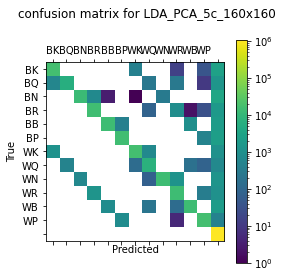

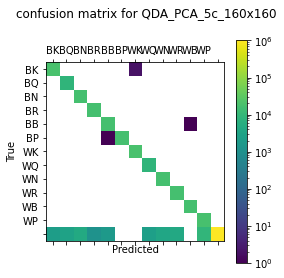

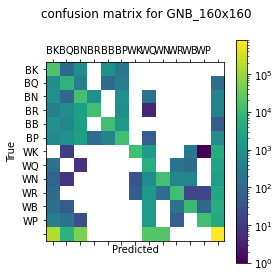

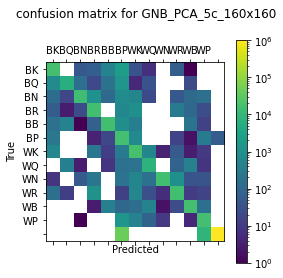

In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def predictor(model, trans):
    def rv(X):
        return model.predict(trans(X))
    return rv

from matplotlib import colors
def plot_confusion_matrix(predfn, modelname):
    y_pred, y_true = apply_transformation(predfn, dl_test,
                                         filename=f'predicted_{modelname}.pkl')
    im = confusion_matrix(y_true, y_pred)
    plt.matshow(im, norm=colors.LogNorm())
    plt.suptitle(f'confusion matrix for {modelname}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.colorbar()
    plt.xticks(range(13), piece_labels)
    plt.yticks(range(13), piece_labels)

plot_confusion_matrix(predictor(lda_pca, forward_transform), 'LDA_PCA_5c_160x160')
plt.show()
plot_confusion_matrix(predictor(qda_pca, forward_transform), 'QDA_PCA_5c_160x160')
plt.show()
plot_confusion_matrix(predictor(gnb_raw, lambda x: x.reshape(len(x), -1)), 'GNB_160x160')
plt.show()
plot_confusion_matrix(predictor(gnb_pca, forward_transform), 'GNB_PCA_5c_160x160')
plt.show()